In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from shapely.geometry import LineString

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString


class Direction:

    def __init__(self, direction, intensity, intersection, width, height) -> None:
        self.direction = direction
        self.intensity = intensity
        self.intersection = intersection
        self.width = width
        self.height = height
        pass

    pass


class LanesDetector:
    def __init__(self, debug=False):
        self.debug = debug
        self.final_image = None
        self.image = None
        self.intersection = None
        self.direction = None
        pass

    @staticmethod
    def plot_image(image, title):
        plt.imshow(image, cmap=plt.cm.gray)
        plt.title(title)
        plt.show()
        pass

    @staticmethod
    def save_image(image, title):
        cv2.imwrite(title, image)
        pass

    @staticmethod
    def load_image(input_path):
        return cv2.imread(input_path)

    def grayscale(self, image):
        # Grayscale the image. Only black and white
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if self.debug:
            LanesDetector.plot_image(grayscale_image, "grayscale")
        return grayscale_image

    def blur(self, image):
        # Smooth the images to optimize the line detection. Removes hard edges
        blur_image = cv2.GaussianBlur(image, (3, 3), 0)
        if self.debug:
            LanesDetector.plot_image(blur_image, "blur")
        return blur_image

    def canny(self, image):
        # Detect all the edges in the image
        canny_image = cv2.Canny(image, 100, 150)
        if self.debug:
            LanesDetector.plot_image(canny_image, "canny")
        return canny_image

    def roi(self, image):
        # Select the region of interest. This should be the most important area of the image.
        # This area should include all the important lanes and other things only as less as possible
        height = image.shape[0]
        width = image.shape[1]
        side_top_padding = height / 2
        side_bottom_padding = height - 50
        middle_top_padding = height / 2
        inner_top_padding = height * 1 / 3

        width1_3 = width * 1 / 3
        width2_3 = width * 2 / 3
        width1_2 = width / 2

        x1 = [0, side_top_padding]
        x2 = [width1_3, inner_top_padding]
        x3 = [width1_2, middle_top_padding]
        x4 = [width2_3, inner_top_padding]
        x5 = [width, side_top_padding]
        x6 = [width, side_bottom_padding]
        x7 = [width1_2, middle_top_padding]
        x8 = [0, side_bottom_padding]

        mask = np.zeros_like(image)
        vertices = [np.array([x1, x2, x3, x4, x5, x6, x7, x8], dtype=np.int32)]
        cv2.fillPoly(mask, vertices, 255)

        if self.debug:
            LanesDetector.plot_image(mask, "mask")
        masked_image = cv2.bitwise_and(image, mask)
        if self.debug:
            LanesDetector.plot_image(masked_image, "roi")
        return masked_image

    @staticmethod
    def scale_line(x1, y1, x2, y2, factor):
        # Scale a line (defined by two points) by a given factor
        t0 = 0.5 * (1.0 - factor)
        t1 = 0.5 * (1.0 + factor)
        x1 = x1 + (x2 - x1) * t0
        y1 = y1 + (y2 - y1) * t0
        x2 = x1 + (x2 - x1) * t1
        y2 = y1 + (y2 - y1) * t1
        return [int(x1), int(y1), int(x2), int(y2)]

    def hough_lines(self, image, rho, theta, threshold, min_line_len, max_line_gap, averaged=False):
        # Detect all lines
        lines_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                                maxLineGap=max_line_gap)
        if lines is not None:
            lines = self.averaged_lines(image, lines, lines_image) if averaged else lines[:, 0]
            for line in lines:
                if line is not None:
                    x1, y1, x2, y2 = line
                    cv2.line(lines_image, (x1, y1), (x2, y2), (255, 255, 255), 20)
            if self.debug:
                LanesDetector.plot_image(lines_image, "lines")
        return lines_image

    def get_intersection(self, left, right):
        # Get the intersection of two lines
        l_left = LineString([[left[0], left[1]], [left[2], left[3]]])
        l_right = LineString([[right[0], right[1]], [right[2], right[3]]])
        point = l_left.intersection(l_right)
        x = int(point.x)
        y = int(point.y)
        self.intersection = [x, y]
        return self.intersection

    @staticmethod
    def merge_lines(image, lines):
        # Helper method to merge multiple lines
        if len(lines) > 0:
            slope, intercept = np.average(lines, axis=0)
            y1 = image.shape[0]
            y2 = int(y1 * (1 / 2))
            x1 = int((y1 - intercept) / slope)
            x2 = int((y2 - intercept) / slope)
            return np.array([x1, y1, x2, y2])

    def averaged_lines(self, image, lines, lines_image):
        # Average mulitple lines and merge them into one per side (left, right)
        right_lines = []
        left_lines = []
        for x1, y1, x2, y2 in lines[:, 0]:
            parameters = np.polyfit((x1, x2), (y1, y2), 1)
            slope = parameters[0]
            intercept = parameters[1]
            if slope >= 0:
                right_lines.append([slope, intercept])
            else:
                left_lines.append([slope, intercept])

        # Merge all detected lines and scale them
        left = self.merge_lines(image, left_lines)
        left = LanesDetector.scale_line(*left, 2)
        right = self.merge_lines(image, right_lines)
        right = LanesDetector.scale_line(*right, 2)

        # Get the intersection of the lines
        x, y = self.get_intersection(left, right)
        cv2.line(lines_image, (x, 0), (x, image.shape[0]), (255, 255, 255), 3)
        middle = int(self.image.shape[1]/2)
        cv2.line(lines_image, (middle, 0), (middle, image.shape[0]), (0, 255, 0), 3)
        self.set_direction()
        # Set the end of the two remaining lines to the intersection
        left[2] = x
        left[3] = y
        right[2] = x
        right[3] = y
        return left, right

    def combine_images(self, edited_image, initial_image, alpha=1, beta=1, gamma=0.0):
        # Convert the image to have equal color dimensions
        edited_image = cv2.cvtColor(edited_image, cv2.COLOR_BGRA2BGR)
        initial_image = cv2.cvtColor(initial_image, cv2.COLOR_BGRA2BGR)
        # Combine the initial and the final image
        combined_image = cv2.addWeighted(edited_image, alpha, initial_image, beta, gamma)
        if self.debug:
            LanesDetector.plot_image(combined_image, "combined")
        return combined_image

    def transform(self, input_path, output_path):
        self.image = LanesDetector.load_image(input_path)

        # Get only the lines in the region of the interest
        final_image = self.grayscale(self.image)
        final_image = self.blur(final_image)
        final_image = self.canny(final_image)
        final_image = self.blur(final_image)
        final_image = self.roi(final_image)
        final_image = self.hough_lines(final_image, 0.9, np.pi / 180, 100, 100, 50)

        # Only detect the striking lines and remove the other ones
        final_image = self.grayscale(final_image)
        final_image = self.blur(final_image)
        final_image = self.canny(final_image)
        final_image = self.blur(final_image)
        final_image = self.hough_lines(final_image, 0.9, np.pi / 180, 100, 100, 50)

        # Average the remaining lines and create a final line on the left and right hand side
        # In addition to this, extend the lines and calculate the intersection of them
        # The intersection is later used to determine the direction to drive
        final_image = self.blur(final_image)
        final_image = self.canny(final_image)
        final_image = self.blur(final_image)
        final_image = self.hough_lines(final_image, 0.9, np.pi / 180, 100, 100, 50, True)
        final_image = self.combine_images(final_image, self.image)
        LanesDetector.save_image(final_image, output_path)
        self.final_image = final_image
        return self

    pass

    def set_direction(self):
        height = self.image.shape[0]
        width = self.image.shape[1]
        x, y = self.intersection

        middle_width = width / 2
        middle_height = height / 5 * 2
        # direction = 1 => forward
        # direction < 1 => left
        # direction > 1 => right
        direction = x / middle_width
        # intensity = 1 => normal
        # intensity < 1 => light
        # intensity > 1 => hard
        intensity = y / middle_height

        self.direction = Direction(direction=direction, intensity=intensity, intersection=self.intersection,
                                   height=height, width=width)
        pass

    pass


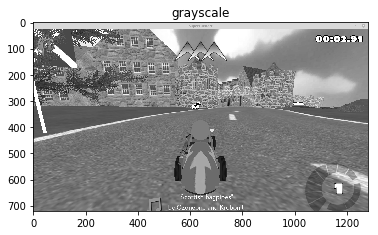

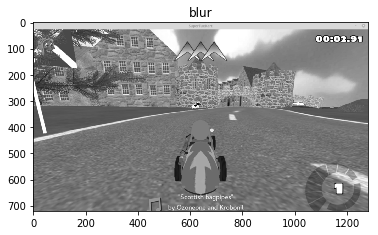

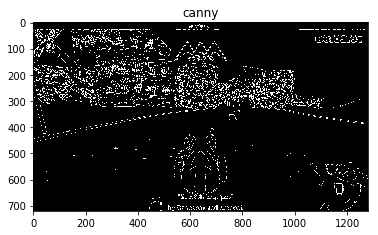

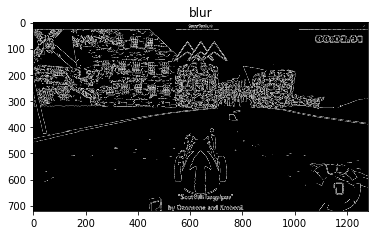

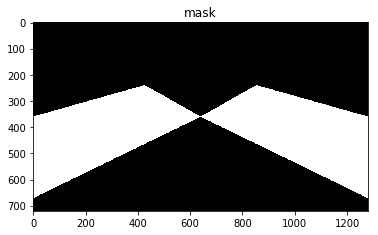

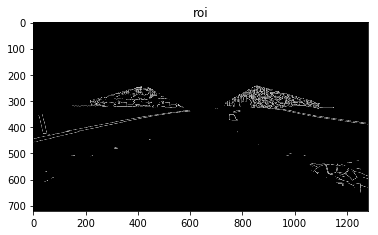

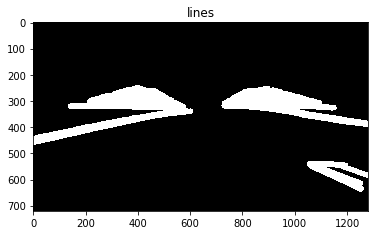

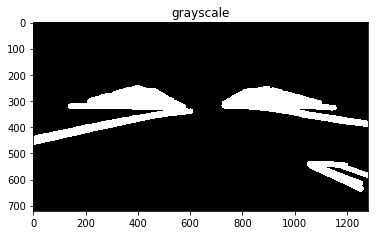

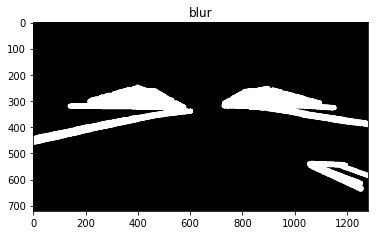

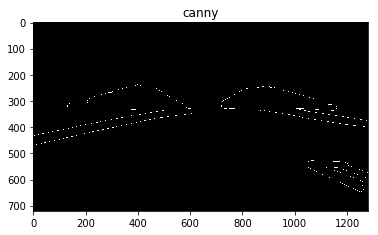

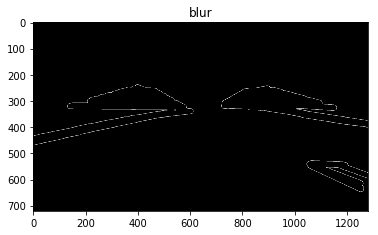

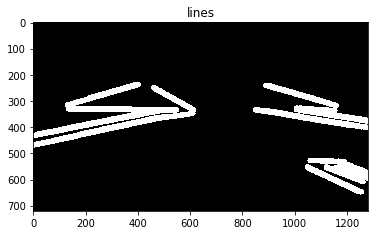

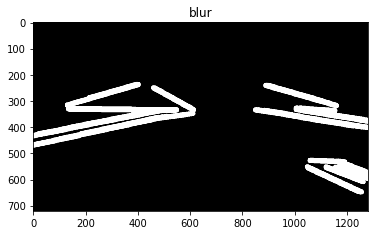

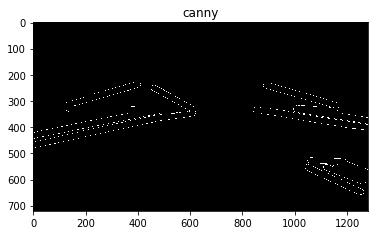

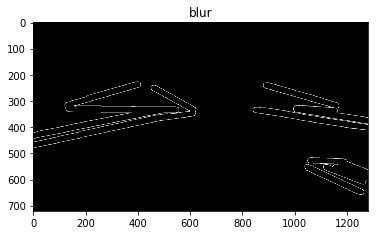

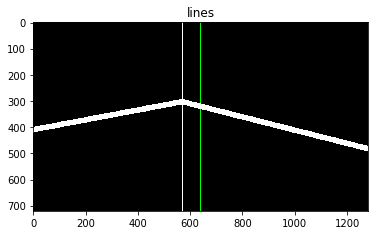

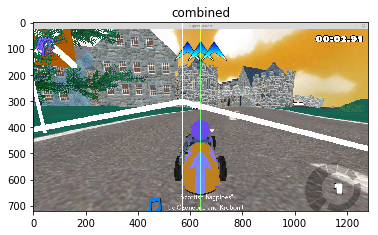

In [13]:
INPUT_FOLDER = "./screenshots/"
OUTPUT_FOLDER = "./output/"
TEST_IMAGE = '1571584584817.png'
LanesDetector(True).transform(INPUT_FOLDER + TEST_IMAGE, OUTPUT_FOLDER + TEST_IMAGE)

In [14]:
# Test Image
directions = []
for filename in os.listdir(INPUT_FOLDER):
    try:
        directions.append(LanesDetector(False).transform(INPUT_FOLDER + filename, OUTPUT_FOLDER + filename).direction)
    except OverflowError:
        print(filename)
    except:
        print(filename)

In [15]:
def map_directions(direction):
    return direction.intensity
for direction in list(map(map_directions, directions)):
    print(direction)

1.0729166666666667
1.0069444444444444
1.0416666666666667
1.0451388888888888
0.9826388888888888
1.0243055555555556
0.9722222222222222
0.9652777777777778
0.9201388888888888
1.0763888888888888
1.09375
0.9166666666666666
1.0451388888888888
1.03125
1.0208333333333333
1.0381944444444444
1.0347222222222223
1.0729166666666667
1.0034722222222223
0.9722222222222222
1.0138888888888888
0.9479166666666666
1.0902777777777777
1.0208333333333333
0.96875
1.0520833333333333
0.8993055555555556
0.9722222222222222
1.0763888888888888
1.0243055555555556
1.0451388888888888
1.0104166666666667
1.0520833333333333
0.9548611111111112
1.0347222222222223
1.0347222222222223
0.9652777777777778
0.9548611111111112
1.0416666666666667
1.0347222222222223
1.0416666666666667
1.1180555555555556
1.0659722222222223
1.0520833333333333
1.03125
1.0347222222222223
0.9930555555555556
